<div class="alert alert-block alert-success"><font color="black"><h1><left>EDA of MIMIC ICU Data for Intestinal Conditions</left></h1></font></div>


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
# File definitions
path = 'E:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-531\Data\\'
file1 = path + 'part-00000-diagnosis-code.snappy.parquet'
file2 = path + 'part-00000-admission-diags.snappy.parquet'
file3 = path + 'part-00000-admissions.snappy.parquet'
file4 = path + 'part-00000-note-events.snappy.parquet'
file6 = path + 'ICD10_Formatted.csv'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Notebook Global Variables</left></h1>
</font></div>

In [3]:
# This variable is used to selected the max size of notes selected for analysis
note_length = 2000
# This dictionary is used to select icd10 codes used for the comparison charts
icd_codes_t = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K57.30':'Colon-1', 'K57.31':'Colon-2', 'K57.32':'Colon-3', 
             'K21.9':'Reflux', 'I27.89':'Heart-1',
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome', 'I27.89':'Heart'}

# This dictionary is used to select icd categories used for the comparison charts
icd_codes2 = {'Ulcer':'darkred','Heart':'yellow',
             'Gastritis':'green','Reflux':'plum',
             'Colitis':'brown','IBS':'blue'}



<div class="alert alert-block alert-success"><font color="black"><h1><left>Generate Core Dataframes</left></h1></font></div>


In [4]:
diag_codes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
admsn_diags = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
admissions = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)
#             [['hadm_id','subject_id','admittime', 'dischtime','diagnosis']]

<div class="alert alert-block alert-success"><font color="black"><h2><left>Read ICD9 to ICD10 Translatiion file</left></h2></font></div>


In [5]:
import re

icd9_df = pd.read_csv(file6,sep='|', header=0)
icd9_df['ICD9'] = icd9_df['ICD9'].astype(str).apply(lambda x: re.sub('\.','', x))
icd9_df[1:5]

,ICD9,ICD10,Description
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A


In [6]:
icd9_df.columns = ['icd9', 'icd10', 'description']
icd9_df.rename({'icd9': 'ICD9', 'icd10': 'ICD10' }, axis=1, inplace=True)
icd9_df

,ICD9,ICD10,description
0,0010,A00.0,"Cholera due to Vibrio cholerae 01, biovar chol..."
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A
...,...,...,...
14810,20311,C90.11,Plasma cell leukemia in remission
14811,20312,C90.12,Plasma cell leukemia in relapse
14812,20380,C88.8,Other malignant immunoproliferative diseases
14813,20381,C90.21,Extramedullary plasmacytoma in remission


In [7]:
terms = 'gastro|gastric|celiac|bowel|colitis|intestinal|pseudo-obstruction|crohns|\
         diverticulitis|malabsorption|bowel|ischemia|reflux|colon|appendix|heart'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Find Diagnosis Codes for Intestinal Conditions and Find Them on Patient Admissions</left></h1></font>

Identified Daignosis Codes : 135
&emsp;Reported Diagnosis Codes : 85
&emsp;Patients with Those Diagnosis: 10,082
&emsp;Patients with Multiple Diagnosis: 854</div>


In [8]:
# Find admissions based on diagnosis associated with admissions
# It generates a dataframe with subject_id, hadm_id, and a list of icd9 codes
# 447 patients have one diagnoses per admission, 6 patients have 2 diagnoses

# find diagnoses with keywords based on terms
wanted_diags = diag_codes[(diag_codes['long_title'].str.contains(terms))] 
# find admissions with wanted diagnoese codes
temp_folks = pd.merge(wanted_diags, admsn_diags, on='icd9_code')[['subject_id', 'hadm_id', 'icd9_code']]
#find unique set of diag codes found associated with a patient
found_diags = temp_folks[['icd9_code']].drop_duplicates()
# turn a patient's diagnoses codes into a list-column (to accomodate mnre than one) 
intestinal_folks = (temp_folks.groupby(['subject_id', 'hadm_id'])['icd9_code']
                             .apply(list)
                             .reset_index(name='icd9_codes')) 
# Find how many admissions with more than 1 diagnosis code
patients_more_than_one = intestinal_folks[intestinal_folks.icd9_codes.map(len) > 1] 
print('wanted diag count: ', wanted_diags.shape[0], ' intestinal_folks count: ', intestinal_folks.shape[0],
     ' found diags: ', len(found_diags), 'more than 1: ', patients_more_than_one.shape[0])
#print the 1st 20 admissins with more than one diagniosis patients with more than one diagnonis code
len(patients_more_than_one.subject_id.unique())

wanted diag count:  276  intestinal_folks count:  23778  found diags:  186 more than 1:  10695


8213

In [9]:
len(intestinal_folks.subject_id.unique())

18294

In [10]:
pd.set_option('display.max_rows',50)
found_diags

,icd9_code
0,0030
2,0090
28,0091
47,0860
51,1641
...,...
39147,E8584
39148,99671
39197,86389
39238,86399


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign Primary ICD9 Diagnosis Code and Translate to ICD10 Code</left></h1></font>

    * Convert icd9-10 conversion table to dictionary
    * Assign primary icd9 and icd10 codes
    * How many have two or more desired diagnosis
    * How many were not assigned an ICD10 code

</div>


In [11]:
import itertools
# icd9_df[1:10]
icd9_dict = dict(zip(icd9_df['ICD9'], icd9_df['ICD10']))
# Get first N items in dictionary
out = dict(itertools.islice(icd9_dict.items(), 10))
         
# printing result
print("Dictionary limited by K is : " + str(out))



icd9_df[icd9_df.ICD10 == 'K25.4']


Dictionary limited by K is : {'0010': 'A00.0', '0011': 'A00.1', '0019': 'A00.9', '0020': 'A01.00', '0021': 'A01.1', '0022': 'A01.2', '0023': 'A01.3', '0029': 'A01.4', '0030': 'A02.0', '0031': 'A02.1'}


,ICD9,ICD10,description
5141,53140,K25.4,Chronic or unspecified gastric ulcer with hemo...
5142,53141,K25.4,Chronic or unspecified gastric ulcer with hemo...


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign ICD10 Daignosis Code</left></h1></font></div>


In [12]:
import numpy as np

def find_primary(dlist, ddict):
    for diag in dlist:
        if diag in ddict:
            return(diag, ddict[diag])
        else:
            return(diag, 'K999')
    return

func1 = np.vectorize(find_primary)


intestinal_folks['primary_icd9_code'],intestinal_folks['primary_icd10_code']\
    = func1(intestinal_folks['icd9_codes'], icd9_dict)


intestinal_folks[intestinal_folks['icd9_codes'].map(len) > 1][1:10]




,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code
11,37,188670,"[4280, 53551]",4280,I50.9
18,56,181711,"[4280, 53140]",4280,I50.9
19,63,195961,"[4148, 4280]",4148,I25.89
21,68,170467,"[4280, 42820]",4280,I50.9
25,83,158569,"[39891, 4148, 53081]",39891,I09.81
32,107,182383,"[4280, 42833]",4280,I50.9
33,109,102024,"[5609, 53140]",5609,K56.60
34,109,126055,"[4168, 53081, 78906]",4168,I27.89
42,115,114585,"[4280, V1000]",4280,I50.9


In [13]:
intestinal_folks[intestinal_folks.primary_icd10_code.str.contains('K51')].groupby('primary_icd10_code').count()

,subject_id,hadm_id,icd9_codes,primary_icd9_code
primary_icd10_code,,,,
K51.00,26,26,26,26
K51.40,3,3,3,3
K51.50,1,1,1,1
K51.80,15,15,15,15
K51.90,164,164,164,164


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign ICD10 Category</left></h1></font></div>


In [14]:
import numpy as np

def assign_category(diag):
    
    
    icd10_categories = {'K50': 'Colitis', 'K51': 'Colitis', 'K52': 'Colitis', 
                        'K29': 'Gastritis', 
                        'K25': 'Ulcer','K26': 'Ulcer', 'K27': 'Ulcer','K28': 'Ulcer','K58': 'IBS','K21': 'Reflux',
                        'I27': 'Heart'}
    
    temp_diag = diag[0:3]
    if temp_diag in icd10_categories:
            return(icd10_categories[temp_diag])
    return

intestinal_folks['icd_category'] = intestinal_folks['primary_icd10_code'].map(lambda x: assign_category(x))


In [15]:
intestinal_folks.groupby('icd_category').count()

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code
icd_category,,,,,
Colitis,396,396,396,396,396
Gastritis,260,260,260,260,260
Heart,1964,1964,1964,1964,1964
IBS,142,142,142,142,142
Reflux,4030,4030,4030,4030,4030
Ulcer,279,279,279,279,279


<div class="alert alert-block alert-success"><font color="black"><h1><left>Tie Relavent Admissions to Admission Data and Calculate Length of Stay in Hours</left></h1></font>

In [16]:
# Find time in hospital (in hours) stats by diagnosis code
admissions['stay_hours'] = (admissions.dischtime - admissions.admittime).astype('timedelta64[h]')
intestinal_adms = pd.merge(intestinal_folks, admissions, on=['subject_id','hadm_id'])\
                [['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code', 'primary_icd10_code', 'stay_hours', \
                  'admittime', 'dischtime','deathtime',\
                 'admission_type', 'insurance', 'language', 'religion','marital_status', 'ethnicity', 'diagnosis', 'icd_category']]
intestinal_adms[intestinal_adms.icd_category == 'Reflux'][0:3]


,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,icd_category
3,24,161859,[53081],53081,K21.9,68.0,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,Private,<NA>,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,Reflux
6,32,175413,[53081],53081,K21.9,460.0,2170-04-04 08:00:00,2170-04-23 12:45:00,NaT,ELECTIVE,Medicaid,<NA>,UNOBTAINABLE,<NA>,WHITE,TRACHEAL STENOSIS/SDA,Reflux
9,36,122659,[53081],53081,K21.9,305.0,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHEST PAIN/SHORTNESS OF BREATH,Reflux


In [17]:
intestinal_adms.admittime = pd.to_datetime(intestinal_adms.admittime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.dischtime = pd.to_datetime(intestinal_adms.dischtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms.deathtime = pd.to_datetime(intestinal_adms.deathtime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
intestinal_adms[0:4]

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,icd_category
0,3,145834,[4280],4280,I50.9,258.0,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,Medicare,<NA>,CATHOLIC,MARRIED,WHITE,HYPOTENSION,None
1,9,150750,[4280],4280,I50.9,117.0,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,Medicaid,<NA>,UNOBTAINABLE,<NA>,UNKNOWN/NOT SPECIFIED,HEMORRHAGIC CVA,None
2,21,109451,[4280],4280,I50.9,315.0,2134-09-11 12:17:00,2134-09-24 16:15:00,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE,None
3,24,161859,[53081],53081,K21.9,68.0,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,Private,<NA>,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,Reflux


In [18]:
# find diag dsescription associared with admission
intestinal_adms.loc[(intestinal_adms.icd_category == 'Reflux'),('subject_id', 'hadm_id', 'icd9_codes','diagnosis')]


,subject_id,hadm_id,icd9_codes,diagnosis
3,24,161859,[53081],INTERIOR MYOCARDIAL INFARCTION
6,32,175413,[53081],TRACHEAL STENOSIS/SDA
9,36,122659,[53081],CHEST PAIN/SHORTNESS OF BREATH
10,36,182104,[53081],CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
16,53,155385,[53081],MYOCARDIAL INFARCTION\CARDIAC CATH
...,...,...,...,...
23763,99912,189380,[53081],PNEUMONIA
23764,99922,123563,[53081],AORTIC STENOSIS\AORTIC VALVE REPLACEMENT /SDA
23769,99946,157197,[53081],PANCREATITIS
23770,99966,167228,[53081],COMPLETE HEART BLOCK


In [19]:
intestinal_adms['hadm_id'].count()

23778

<div class="alert alert-block alert-success"><font color="black"><h1><left>Length of Stay Statistics and Admission Counts By Primary Diagnosis Code</left></h1></font>

In [20]:
intestinal_adms.merge(diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
                        .groupby(['primary_icd10_code', 'primary_icd9_code' , 'icd_category', 'long_title'])\
                        .agg(stay_hrs_min= ('stay_hours','min'),
                             stay_hrs_max= ('stay_hours','max'),
                             stay_hrs_avg= ('stay_hours','mean'),
                             adms_count=('hadm_id','count'))\
                         .round(1)\
                         .sort_values(by=['adms_count'], ascending=False, inplace=False)[1:30]

,,,,stay_hrs_min,stay_hrs_max,stay_hrs_avg,adms_count
primary_icd10_code,primary_icd9_code,icd_category,long_title,,,,
I27.89,4168,Heart,Other chronic pulmonary heart diseases,-1.0,3152.0,257.4,1894
K29.90,53550,Gastritis,"Unspecified gastritis and gastroduodenitis, without mention of hemorrhage",9.0,3048.0,224.7,189
K51.90,5569,Colitis,"Ulcerative colitis, unspecified",1.0,3194.0,243.1,164
K25.4,53140,Ulcer,"Chronic or unspecified gastric ulcer with hemorrhage, without mention of obstruction",19.0,2081.0,197.9,163
K58.9,5641,IBS,Irritable bowel syndrome,6.0,1194.0,190.9,142
K52.9,5589,Colitis,Other and unspecified noninfectious gastroenteritis and colitis,20.0,4954.0,304.6,136
K29.91,53551,Gastritis,"Unspecified gastritis and gastroduodenitis, with hemorrhage",28.0,1328.0,204.4,71
I27.81,4169,Heart,"Chronic pulmonary heart disease, unspecified",-1.0,998.0,253.9,70
K25.0,53100,Ulcer,"Acute gastric ulcer with hemorrhage, without mention of obstruction",35.0,1699.0,276.6,43


In [21]:
intestinal_adms.groupby('icd_category').count()
intestinal_adms.groupby('icd_category')\
                       .agg(stay_hrs_min= ('stay_hours','min'),
                        stay_hrs_max= ('stay_hours','max'),
                           stay_hrs_avg= ('stay_hours','median'),
                           adms_count=('hadm_id','count'))\
                       .round(1)\
                       .sort_values(by=['adms_count'], ascending=False, inplace=False)

,stay_hrs_min,stay_hrs_max,stay_hrs_avg,adms_count
icd_category,,,,
Reflux,-19.0,4059.0,148.0,4030
Heart,-1.0,3152.0,191.0,1964
Colitis,1.0,4954.0,197.5,396
Ulcer,19.0,2848.0,113.0,279
Gastritis,9.0,3048.0,135.0,260
IBS,6.0,1194.0,130.5,142


In [22]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 30)
print(intestinal_adms.shape)
intestinal_adms.columns

(23778, 17)


Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category'],
      dtype='object')

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare Diagnosis By Length of Stay</left>
</h2></font>

The next three charts depict length of stay by diagnosis. Since there is a wide gap in frequency across diagnosis, 
I grouped the diagnoses by frequency dividing them into across 3 charts</div>

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine diagnosis code with the largest counts and the largest length of stay</left>
</h2></font>

In [23]:
intestinal_adms.columns
# intestinal_adms.groupby(icd_category).count()

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category'],
      dtype='object')

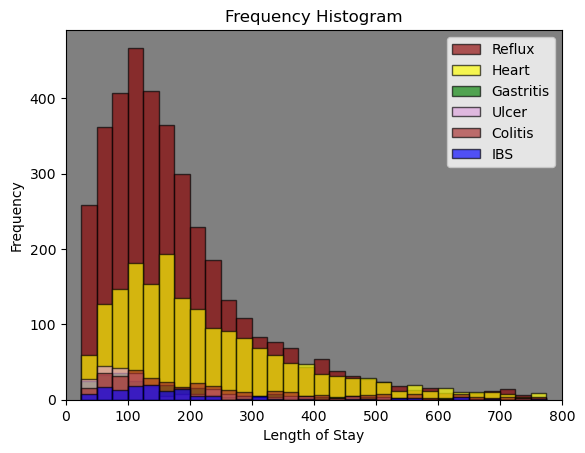

In [24]:
# I need to change this so that the icd global table incoroprates color
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset=['primary_icd10_code', 'icd_category'])

icd_codes2 = {'Reflux':'darkred','Heart':'yellow',
             'Gastritis':'green','Ulcer':'plum',
             'Colitis':'brown','IBS':'blue'}

abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")

temp_vert = 100

for code, description in icd_codes2.items():
#    print('data: ', code, ' ' , description)
    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code), 'stay_hours']
#    print('size: ', len(temp_x))
    ax.hist(temp_x, **kwargs, color=description, edgecolor='black', label=code)
    temp_text = ' N = ' + str(len(temp_x))
    temp_vert -= 2


plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,800)
plt.legend()
plt.show()

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes in Side-By-Side Charts</left>
</h2></font>

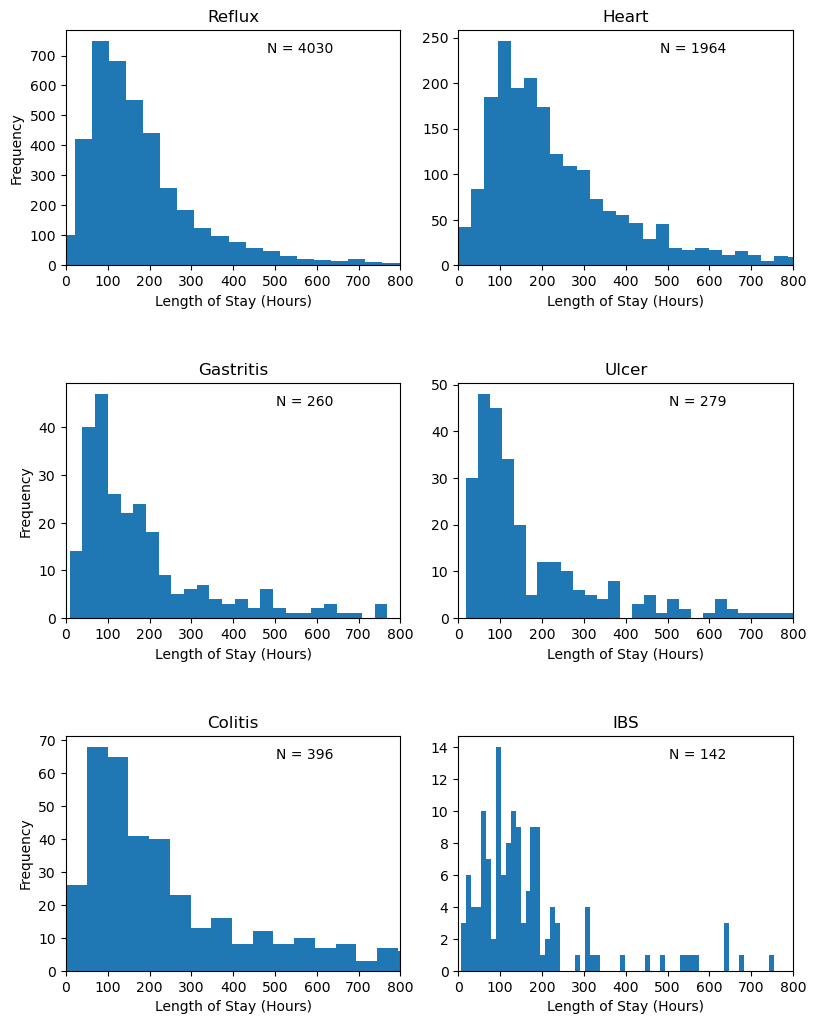

In [25]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)


x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code), 'stay_hours']
    
    atext = 'N = ' + str(len(temp_x))
    axis[x_row,x_col].hist(temp_x, bins=100)
    axis[x_row,x_col].set_xlim(0,800)
    xtitle = code
    # xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.8, 0.95, atext, horizontalalignment='right', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xlabel('Length of Stay (Hours)')
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
        
        

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes Boxplots</left>
</h2></font>

Reflux darkred
Heart yellow
Gastritis green
Ulcer plum
Colitis brown
IBS blue


[Text(0, 1, 'Reflux'),
 Text(0, 2, 'Heart'),
 Text(0, 3, 'Gastritis'),
 Text(0, 4, 'Ulcer'),
 Text(0, 5, 'Colitis'),
 Text(0, 6, 'IBS')]

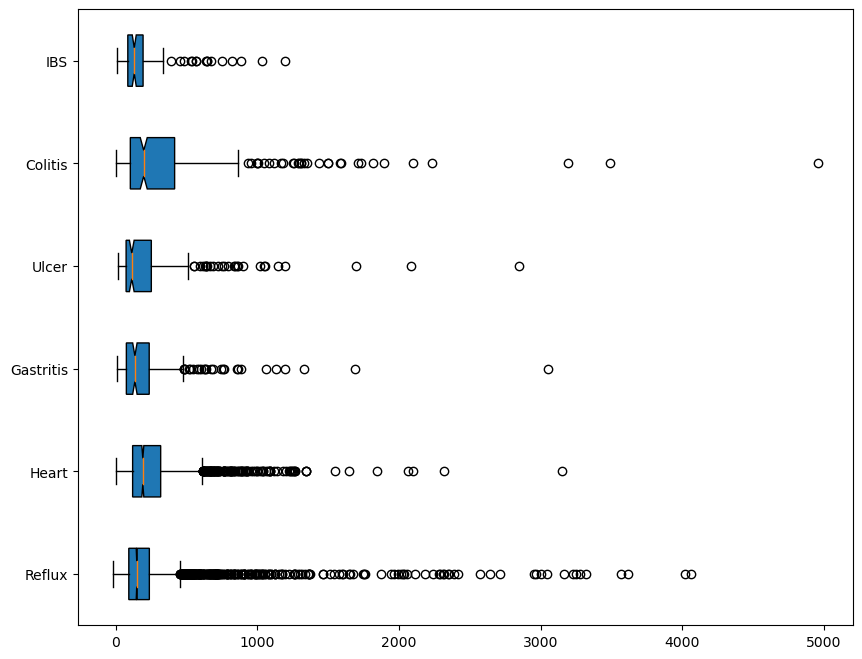

In [26]:

fig = plt.figure(figsize =(10, 8))
ax = fig.add_subplot(111)
 
def get_data(code):
    
#    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']

    temp_x = intestinal_adms.loc[intestinal_adms['icd_category'].str.contains(code,na=False), 'stay_hours']
    return temp_x

x_data = []
x_description = []
x_items = 0

#for code, description in icd_codes_t.items():
for code, description in icd_codes2.items():
    print(code, description)
    x_description.append(code)
    x_data.append(get_data(code))
    

# Creating axes instance
bp = ax.boxplot(x_data, patch_artist = True,
                notch ='True', vert = 0)

ax.set_yticklabels(x_description)



<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare the LOS for Emergency vs Elective</left>
</h2></font>

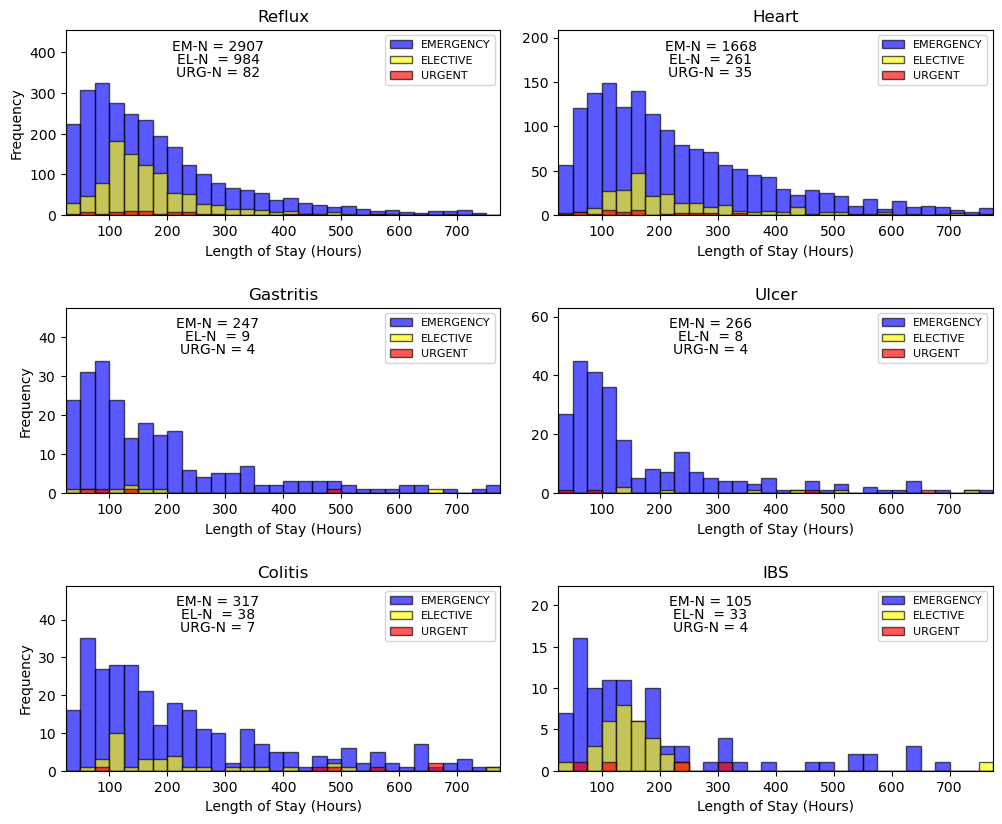

In [27]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
#   xem = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xem = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
#   xel = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xel = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'ELECTIVE'),'stay_hours']
#    xur = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    xur = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &                              
    (intestinal_adms['admission_type'] == 'URGENT'),'stay_hours']
    

    atext = 'EM-N = ' + str(len(xem))
    btext = 'EL-N  = ' + str(len(xel))
    ctext = 'URG-N = ' + str(len(xur))

    
    axis[x_row,x_col].hist(xem, **kwargs, color='blue', edgecolor='black',label='EMERGENCY')
    axis[x_row,x_col].hist(xel, **kwargs, color='yellow', edgecolor='black',label='ELECTIVE')
    axis[x_row,x_col].hist(xur, **kwargs, color='red', edgecolor='black',label='URGENT')
    
    # xtitle = code + ' ' + description
    xtitle = code
    axis[x_row,x_col].text(0.35, 0.95, atext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.35, 0.88, btext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.35, 0.81, ctext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_xlabel('Length of Stay (Hours)')
    
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.40)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    


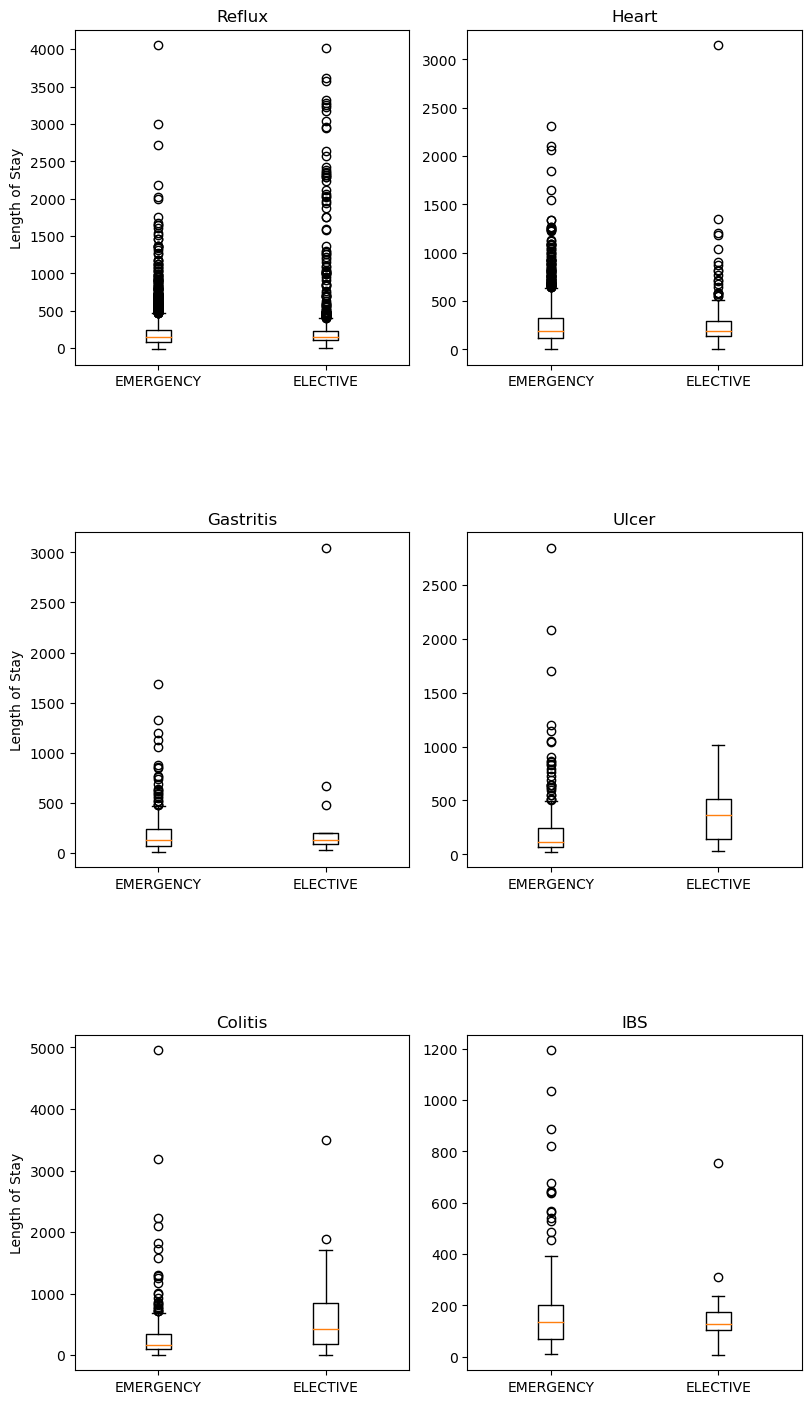

In [28]:
figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(8, 14))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
# abins = range(25,800,25)
# kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
    
    temp_xm = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
    temp_xs = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['admission_type'] != 'EMERGENCY'),'stay_hours']
    temp_data = [temp_xm, temp_xs]
    axis[x_row,x_col].boxplot(temp_data)
    xtitle = code
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticklabels(['EMERGENCY', 'ELECTIVE'])
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Length of Stay')
        x_col += 1
    else:
        x_row += 1
        x_col = 0


In [29]:
#intestinal_adms.columns
intestinal_adms[['icd_category']].groupby(['icd_category'])\
                                 .size().reset_index(name='Total')\
                                 .sort_values('Total', ascending=False)
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
# intestinal_adms

,icd_category,Total
4,Reflux,4030
2,Heart,1964
0,Colitis,396
5,Ulcer,279
1,Gastritis,260
3,IBS,142


In [30]:
#intestinal_adms.columns
ethnicity_adms = intestinal_adms[['ethnicity','icd_category']].groupby(['ethnicity','icd_category'])\
                                                                    .size().reset_index(name='Total')\
                                                                    .sort_values('Total', ascending=False)
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
ethnicity_adms

,ethnicity,icd_category,Total
106,WHITE,Reflux,3020
104,WHITE,Heart,1371
102,WHITE,Colitis,306
34,BLACK/AFRICAN AMERICAN,Reflux,303
32,BLACK/AFRICAN AMERICAN,Heart,265
...,...,...,...
41,BLACK/HAITIAN,Colitis,1
39,BLACK/CAPE VERDEAN,IBS,1
94,UNABLE TO OBTAIN,IBS,1
69,HISPANIC/LATINO - SALVADORAN,Gastritis,1


<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Ethnicity</left>
</h2></font>

In [31]:
def set_ethnic_group(ethnicity):
    if 'WHITE' in ethnicity:
        return 'W'
    elif 'BLACK' in ethnicity:
        return 'B'
    elif 'UNKNOWN' in ethnicity:
        return 'U'
    elif 'DECLINE' in ethnicity:
        return 'U'
    elif 'UNABLE' in ethnicity:
        return 'U'
    elif 'ASIAN' in ethnicity:
        return 'A'
    elif 'HISPANIC' in ethnicity:
        return 'H'
    elif 'NATIVE' in ethnicity:
        return 'I'
    elif 'CARIBBEAN' in ethnicity:
        return 'I'
    elif 'AMERICAN INDIAN' in ethnicity:
        return 'I'
    elif 'PORTUGUESE' in ethnicity:
        return 'W'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'M'
    elif 'SOUTH AMERICAN' in ethnicity:
        return 'W'
    else:
        return 'O'


# df['add'] = df.apply(lambda row : add(row['A'], row['B'], row['C']), axis = 1)    
intestinal_adms['ethnic_group'] = intestinal_adms.apply(lambda row: set_ethnic_group(row['ethnicity']), axis = 1)


In [32]:
intestinal_adms.shape 

(7071, 18)

In [33]:
intestinal_adms.groupby(['ethnic_group','ethnicity'])['hadm_id'].count() 

ethnic_group  ethnicity                                
A             ASIAN                                          83
              ASIAN - ASIAN INDIAN                           10
              ASIAN - CAMBODIAN                               2
              ASIAN - CHINESE                                35
              ASIAN - FILIPINO                                2
              ASIAN - JAPANESE                                2
              ASIAN - KOREAN                                  1
              ASIAN - OTHER                                   2
              ASIAN - THAI                                    1
              ASIAN - VIETNAMESE                              9
B             BLACK/AFRICAN                                   8
              BLACK/AFRICAN AMERICAN                        668
              BLACK/CAPE VERDEAN                             24
              BLACK/HAITIAN                                  22
H             HISPANIC OR LATINO                

In [34]:
# Testing Ethnicity
intestinal_adms.groupby('ethnic_group').size().reset_index(name='Total')

,ethnic_group,Total
0,A,147
1,B,722
2,H,250
3,I,6
4,M,9
5,O,137
6,U,552
7,W,5248


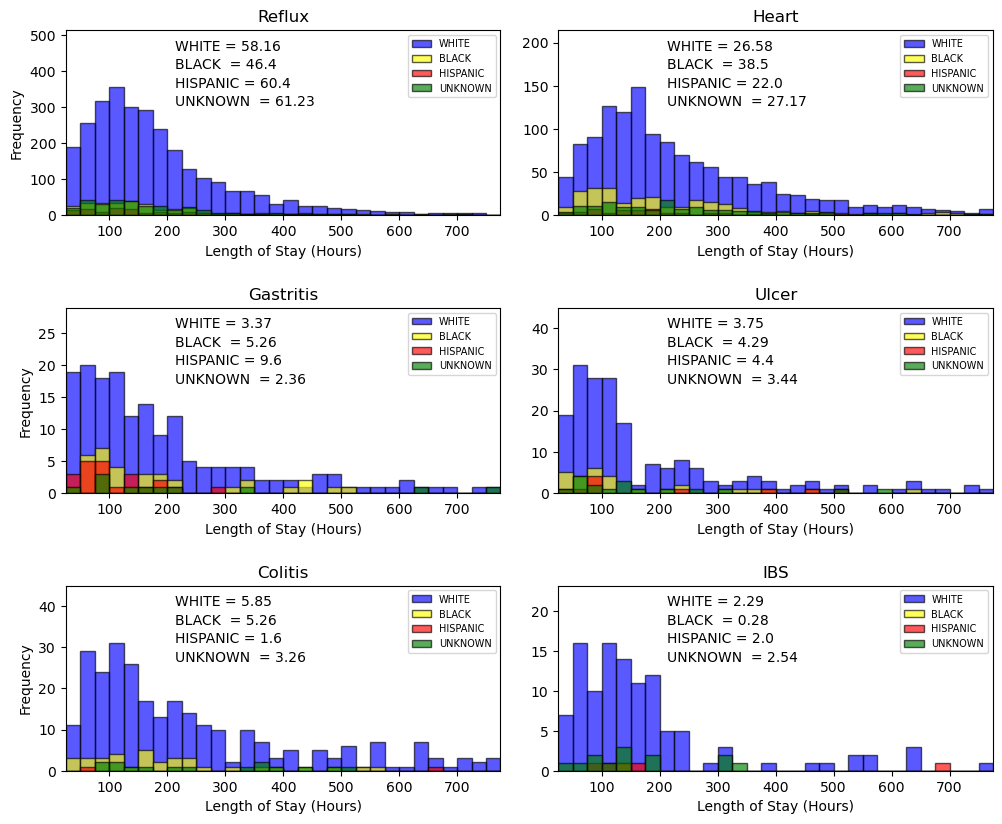

In [35]:
# Compare Length of Stay and Ethnicity
# Initialize the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 0
x_col = 0

for code, description in icd_codes2.items():
        
    temp_xw = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'W'),'stay_hours']
    temp_xb = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'B'),'stay_hours']
    temp_xh = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'H'),'stay_hours']
    temp_xu = intestinal_adms.loc[(intestinal_adms['icd_category'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'U'),'stay_hours']
  #  temp_xo = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
  #                      (intestinal_adms['ethnic_group'] in ['O','A','I','M']),'stay_hours']
    
    wn = len(temp_xw)
    bn = len(temp_xb)
    hn = len(temp_xh)
    un = len(temp_xu)
  #  on = len(temp_xo)
    
    twn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'W')])
    tbn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'B')])
    thn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'H')])
    tun = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'U')])
     
    atext = 'WHITE = ' + str(round((len(temp_xw)/twn)*100,2))
    btext = 'BLACK  = ' + str(round((len(temp_xb)/tbn)*100,2))
    ctext = 'HISPANIC = ' + str(round((len(temp_xh)/thn)*100,2))
    dtext = 'UNKNOWN  = ' + str(round((len(temp_xu)/tun)*100,2))
 #   etext = 'OTHER = ' + str(len(temp_xo))
    
     
    axis[x_row,x_col].hist(temp_xw, **kwargs, color='blue', edgecolor='black',label='WHITE')
    axis[x_row,x_col].hist(temp_xb, **kwargs, color='yellow', edgecolor='black',label='BLACK')
    axis[x_row,x_col].hist(temp_xh, **kwargs, color='red', edgecolor='black',label='HISPANIC')
    axis[x_row,x_col].hist(temp_xu, **kwargs, color='green', edgecolor='black',label='UNKNOWN')
   # axis[x_row,x_col].hist(temp_xo, **kwargs, color='purple', edgecolor='black',label='OTHER')
    xtitle = code
    axis[x_row,x_col].text(0.25, 0.95, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.85, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.75, ctext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.65, dtext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    # axis[x_row,x_col].text(0.35, 0.55, etext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].set_xlabel('Length of Stay (Hours)')
    axis[x_row,x_col].legend(fontsize="7")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.45)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0


In [36]:
# patients with more than one admission
# 10% intestinal folks have more than one admission
gt2admin = intestinal_adms.groupby(['subject_id', ])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)

counts = gt2admin.loc[gt2admin['count'] > 1]['count']
print('totals: ', sum(gt2admin['count']), ' number: ', len(counts))

totals:  7071  number:  634


In [37]:
# Count admissions by primary diagnosis
icd10_counts = intestinal_adms.groupby(['primary_icd10_code','primary_icd9_code'])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
icd10_count_details = pd.merge(icd10_counts, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]
print('total admissions: ', sum(icd10_count_details['count']), ' total codes: ', icd10_count_details.shape[0])
icd10_count_details[1:20]

total admissions:  7071  total codes:  31


,primary_icd10_code,icd9_code,long_title,count
1,I27.89,4168,Other chronic pulmonary heart diseases,1894
2,K29.90,53550,"Unspecified gastritis and gastroduodenitis, wi...",189
3,K51.90,5569,"Ulcerative colitis, unspecified",164
4,K25.4,53140,Chronic or unspecified gastric ulcer with hemo...,163
5,K58.9,5641,Irritable bowel syndrome,142
6,K52.9,5589,Other and unspecified noninfectious gastroente...,136
7,K29.91,53551,"Unspecified gastritis and gastroduodenitis, wi...",71
8,I27.81,4169,"Chronic pulmonary heart disease, unspecified",70
9,K25.0,53100,"Acute gastric ulcer with hemorrhage, without m...",43
10,K52.2,5583,Allergic gastroenteritis and colitis,34


In [38]:
# wanted_icd10_codes = ['K21.9', 'K25.0','K25.4','K29.90','K29.91','K51.00','K51.90','K56.60', 'K56.69','K52.9',
#                      'K52.30','K52.31','K52.32','I27.89','K58.9', 'K92.2']

wanted_icd_categories = ['Colitis', 'Heart','Gastritis','Ulcer','IBS','Reflux']

spec_intel_adms = intestinal_adms.loc[intestinal_adms['icd_category'].isin(wanted_icd_categories)]
len(spec_intel_adms)

7071

In [39]:
# Count admissions by primary diagnosis
"""spec_intel_adms['primary_icd9_code'] =  spec_intel_adms['primary_icd9_code'].astype('string') 
icd10_countsb = spec_intel_adms.groupby(['primary_icd10_code','primary_icd9_code'])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
icd10_count_detailsb = pd.merge(icd10_countsb, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]
icd10_count_detailsb"""

"spec_intel_adms['primary_icd9_code'] =  spec_intel_adms['primary_icd9_code'].astype('string') \nicd10_countsb = spec_intel_adms.groupby(['primary_icd10_code','primary_icd9_code'])['hadm_id'].count()               .reset_index(name='count')               .sort_values(['count'], ascending=False)\nicd10_count_detailsb = pd.merge(icd10_countsb, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]\nicd10_count_detailsb"

In [40]:
# if roland == ready:
#    print(got here)

<div class="alert alert-block alert-success"><font color="black"><h1><left>
Include Notes to Admissions for the Intestinal Conditions</left></h1></font>

- Include only Nurse and Physician Notes
- Inclue Only Emergency and Urgent Admissions
- Format admittime and chartdate as dates
- Put aside discharge notes</div>

In [41]:
spec_intel_adms[1:5]

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,icd_category,ethnic_group
6,32,175413,[53081],53081,K21.9,460.0,2170-04-04 08:00:00,2170-04-23 12:45:00,NaT,ELECTIVE,Medicaid,<NA>,UNOBTAINABLE,<NA>,WHITE,TRACHEAL STENOSIS/SDA,Reflux,W
9,36,122659,[53081],53081,K21.9,305.0,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHEST PAIN/SHORTNESS OF BREATH,Reflux,W
10,36,182104,[53081],53081,K21.9,198.0,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,Reflux,W
16,53,155385,[53081],53081,K21.9,69.0,2170-03-20 20:20:00,2170-03-23 18:00:00,NaT,EMERGENCY,Private,ENGL,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,MYOCARDIAL INFARCTION\CARDIAC CATH,Reflux,U


In [42]:
# get nurses and physician notes

notes = pd.read_parquet(file4,engine='auto',use_nullable_dtypes=True)

In [43]:
# For some reason, the physician category has a space at the end!' 
sel_categories = ['Nursing/other','Nursing','Discharge summary', 'Physician ']
pn_notes = notes.loc[notes['category'].isin(sel_categories)]
# pn_notes = notes 
print('selected notes: ', pn_notes.shape)
print(pn_notes.shape)
notes.groupby('category')['hadm_id'].count()

selected notes:  (1247329, 11)
(1247329, 11)


category
Case Management         954
Consult                  98
Discharge summary     59652
ECG                  138190
Echo                  34037
General                8209
Nursing              220758
Nursing/other        821258
Nutrition              9378
Pharmacy                102
Physician            140100
Radiology            378920
Rehab Services         5409
Respiratory           31667
Social Work            2612
Name: hadm_id, dtype: int64

In [44]:
# remove newborn and elective admissions
wanted_adm_types = ['EMERGENCY', 'URGENT']
spec_intel_adms = spec_intel_adms.loc[spec_intel_adms['admission_type'].isin(wanted_adm_types)]
print('admission subset: ', spec_intel_adms.shape)
spec_intel_adms.groupby('admission_type')['hadm_id'].count()

admission subset:  (5646, 18)


admission_type
EMERGENCY    5510
URGENT        136
Name: hadm_id, dtype: int64

In [45]:
spec_intel_adms.groupby('icd_category').count()

,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,ethnic_group
icd_category,,,,,,,,,,,,,,,,,
Colitis,324,324,324,324,324,324,324,324,33,324,324,253,322,314,324,324,324
Gastritis,251,251,251,251,251,251,251,251,12,251,251,195,251,246,251,251,251
Heart,1703,1703,1703,1703,1703,1703,1703,1703,229,1703,1703,1390,1700,1653,1703,1703,1703
IBS,109,109,109,109,109,109,109,109,6,109,109,93,109,104,109,109,109
Reflux,2989,2989,2989,2989,2989,2989,2989,2989,252,2989,2989,2323,2978,2900,2989,2989,2989
Ulcer,270,270,270,270,270,270,270,270,10,270,270,190,268,259,270,270,270


In [46]:
# put discharge notes aside
discharge_notes = pn_notes.loc[pn_notes['category'] == 'Discharge summary']
discharge_notes = discharge_notes.sort_values(by=['subject_id','hadm_id','chartdate'])
discharge_notes = pd.merge(spec_intel_adms, discharge_notes, on=['subject_id','hadm_id'])
print('discharge notes: ', discharge_notes.shape)

discharge notes:  (6027, 27)


In [47]:
discharge_notes.columns

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'row_id', 'chartdate', 'charttime', 'storetime',
       'category', 'description', 'cgid', 'iserror', 'text'],
      dtype='object')

In [48]:
spec_intel_adms.hadm_id = spec_intel_adms.hadm_id.astype('Int64')
pn_notes.hadm_id = pn_notes.hadm_id.astype('Int64')
# Sort by subject_ID, HAD_ID then CHARTDATE
pn_notes = pn_notes.sort_values(by=['subject_id','hadm_id','chartdate'])
# Merge notes table to admissions table
intsl_notes = pd.merge(spec_intel_adms, pn_notes[pn_notes['category']!= 'Discharge summary'],
                        on = ['subject_id','hadm_id'],
                        how = 'left')
print(intsl_notes.columns)
intsl_notes.shape

D:\ProgramFiles\anaconda3\envs\research\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'row_id', 'chartdate', 'charttime', 'storetime',
       'category', 'description', 'cgid', 'iserror', 'text'],
      dtype='object')


(91962, 27)

In [49]:
intsl_notes.columns
#intsl_notes.groupby('category').count()

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'row_id', 'chartdate', 'charttime', 'storetime',
       'category', 'description', 'cgid', 'iserror', 'text'],
      dtype='object')

In [50]:
len(intsl_notes.hadm_id.unique())

5646

In [51]:
import pandasql as ps

qintsl = intsl_notes[['subject_id', 'hadm_id']]
# print(qintsl.dtypes)
q1 = """SELECT distinct subject_id, hadm_id FROM qintsl """

p1 = ps.sqldf(q1, locals())
print(len(p1))


5646


In [52]:
# Grab date only, not the time
intsl_notes.admittime_c = intsl_notes.admittime.apply(lambda x: str(x).split(' ')[0])

intsl_notes['admittime_c'] = pd.to_datetime(intsl_notes.admittime_c, format = '%Y-%m-%d', errors = 'coerce')
intsl_notes['chartdate'] = pd.to_datetime(intsl_notes.chartdate, format = '%Y-%m-%d', errors = 'coerce')

C:\Users\rolan\AppData\Local\Temp\ipykernel_1880\2514053595.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  intsl_notes.admittime_c = intsl_notes.admittime.apply(lambda x: str(x).split(' ')[0])


In [53]:
# This functuion selects notes within 3 days of admission date and merges them onto admission data
def less_n_days_data(df_adm_notes, n):
    print('initial: ',len(df_adm_notes))
    df_less_n = df_adm_notes[
        ((df_adm_notes['chartdate'] - df_adm_notes['admittime_c']).dt.total_seconds() / (24 * 60 * 60)) < n]
    df_less_n = df_less_n[df_less_n['text'].notnull()]
    print('less_n: ',len(df_less_n))
    df_concat = pd.DataFrame(df_less_n.groupby(['subject_id','hadm_id'])['text'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    print('final: ',len(df_concat))
    df_concat['text'] = df_concat['text'].str.lstrip()
    df_concat['note_length'] = df_concat['text'].apply(len)
    return df_concat

In [54]:

intsl_notes_less_3 = less_n_days_data(intsl_notes[intsl_notes['stay_hours'] >= 84], 3)

initial:  85053
less_n:  24885
final:  2289


In [55]:
print(intsl_notes_less_3.columns)
intsl_notes_less_3[0:5]


Index(['subject_id', 'hadm_id', 'text', 'note_length'], dtype='object')


,subject_id,hadm_id,text,note_length
0,85,116630,Nursing 11a-11p\nSee adm hx for pmh & events l...,6297
1,109,126055,Chief Complaint: hypertensive urgency\n I s...,102173
2,109,155726,Chief Complaint: Dyspnea and hypertensive eme...,60669
3,109,173633,"Chief Complaint: abdominal pain, headache, di...",131700
4,112,174105,NURSING MICU NOTE 7P-7A\n\nPT [**Name (NI) 577...,1646


In [56]:
intsl_notes_less_3 = intsl_notes_less_3.sort_values(by=['subject_id','hadm_id'])
intsl_notes = pd.merge(spec_intel_adms, intsl_notes_less_3,
                        on = ['subject_id','hadm_id'],
                        how = 'inner')
print('intsl_notes columns: ',intsl_notes.columns)
print('intsl_notes shape: ',intsl_notes.shape)
print('unique-admissions: ',len(intsl_notes['hadm_id'].unique()))
intsl_notes[0:2]

intsl_notes columns:  Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length'],
      dtype='object')
intsl_notes shape:  (2289, 20)
unique-admissions:  2289


,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,admittime,dischtime,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis,icd_category,ethnic_group,text,note_length
0,85,116630,[53081],53081,K21.9,191.0,2162-03-02 14:04:00,2162-03-10 13:15:00,NaT,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CARDIAC CATH,Reflux,W,Nursing 11a-11p\nSee adm hx for pmh & events l...,6297
1,109,126055,"[4168, 53081, 78906]",4168,I27.89,499.0,2141-10-13 23:10:00,2141-11-03 18:45:00,NaT,EMERGENCY,Medicaid,ENGL,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,ABDOMINAL PAIN,Heart,B,Chief Complaint: hypertensive urgency\n I s...,102173


<div class="alert alert-block alert-success"><font color="black"><h1><left>Note Sizes and Counts By Diagnosis Code For Combined Notes</left></h1></font></div>

In [57]:
lnotes = intsl_notes.groupby(['icd_category']).agg(min=('note_length', 'min'), median=('note_length','median'),
                                                            max=('note_length','max') , count=('hadm_id','count')).round(1)
print(lnotes)

admstayhrs = intsl_notes.groupby(['icd_category']).agg(min=('stay_hours', 'min'), median=('stay_hours','median'),
                                                            max=('stay_hours','max') , count=('hadm_id','count')).round(1)
admstayhrs.columns

               min  median     max  count
icd_category                             
Colitis        792    7608  172228    129
Gastritis      495    7298  187116    103
Heart          397   10816  234603    695
IBS           1754   21102  150866     33
Reflux         235    6908  318862   1212
Ulcer         1002    5243  192715    117


Index(['min', 'median', 'max', 'count'], dtype='object')

<div class="alert alert-block alert-success"><font color="black"><h1><left>Is There a Relationship between Length of Stay and Note Size</left></h1></font></div>

Heart Reflux
Gastritis Colitis
Ulcer IBS


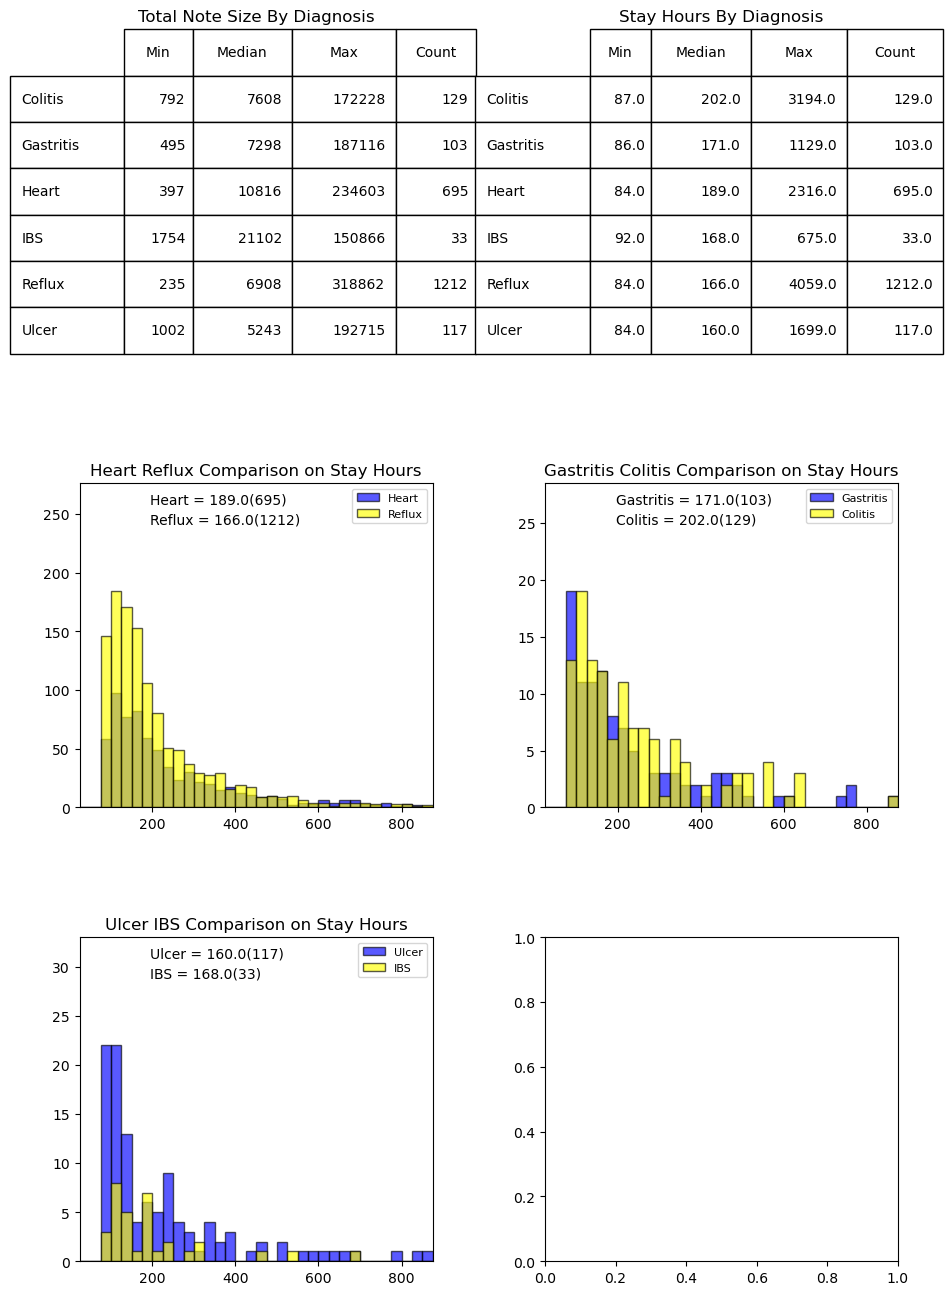

In [58]:
import matplotlib.pyplot as plt
import pandas as pd


figure, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 14))
figure.tight_layout(pad=5.0) # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.4)

bbox = [0, 0, 1, 1]
axis[0,0].axis('tight')
axis[0,0].axis('off')
axis[0,0].set_title('Total Note Size By Diagnosis')
axis[0,0].margins(0,0.50)
clabels = ['Min', 'Median', 'Max', 'Count']
mpl_table = axis[0,0].table(cellText=lnotes.values, rowLabels=lnotes.index, bbox=bbox, colLabels=clabels)
mpl_table.auto_set_column_width(col=list(range(len(lnotes.columns))))
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(10)
mpl_table.scale(4,5)

sbbox = [0, 0, 1, 1]
axis[0,1].axis('tight')
axis[0,1].axis('off')
axis[0,1].set_title('Stay Hours By Diagnosis')
slabels = ['Min', 'Median', 'Max', 'Count']
axis[0,1].margins(0,0.50)
spl_table = axis[0,1].table(cellText=admstayhrs.values, rowLabels=admstayhrs.index, bbox=sbbox, colLabels=slabels)
spl_table.auto_set_font_size(False)
spl_table.auto_set_column_width(col=list(range(len(admstayhrs.columns))))
spl_table.set_fontsize(10)
spl_table.scale(4,5)
                          
                          
icd_codes_groups = {'Heart':'Reflux','Gastritis':'Colitis','Ulcer':'IBS'}

abins = range(25,900,25)
kwargs = dict(alpha=0.65, bins=abins)

x_row = 1
x_col = 0

for code_1, code_2 in icd_codes_groups.items():
    
    print(code_1, code_2)

    xm = intsl_notes.loc[(intsl_notes['icd_category'].str.contains(code_1)),'stay_hours']
    xs = intsl_notes.loc[(intsl_notes['icd_category'].str.contains(code_2)),'stay_hours']
    
    atext = code_1 + ' = ' + str(xm.median()) + '(' + str(xm.count()) + ')'
    btext = code_2 + ' = ' + str(xs.median()) + '(' + str(xs.count()) + ')'
    
    
    axis[x_row,x_col].hist(xm, **kwargs, color='blue', edgecolor='black',label=str(code_1))
    axis[x_row,x_col].hist(xs, **kwargs, color='yellow', edgecolor='black',label=str(code_2))
    xtitle = code_1 + ' ' + code_2 + ' Comparison on Stay Hours'
    axis[x_row,x_col].text(0.20, 0.97, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.20, 0.91, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.50) 
    if x_col == 0:
        x_col += 1
    else:
        x_row += 1
        x_col = 0
plt.show()

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length'],
      dtype='object')


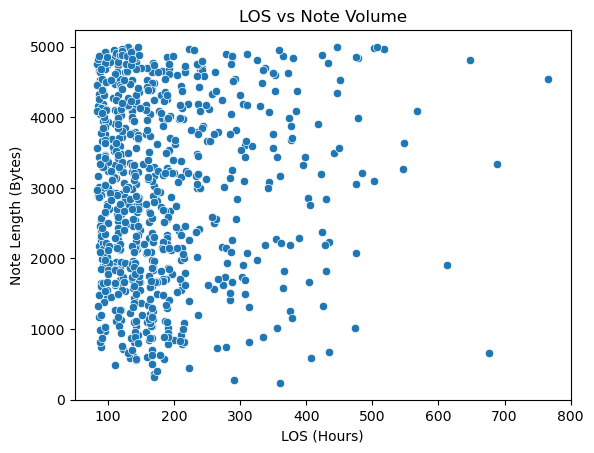

In [59]:
import seaborn as sns

print(intsl_notes.columns)
# print(type(lnotes))
# median_note_size = lnotes['median']
# median_los = admstayhrs['median']
ax = sns.scatterplot(x='stay_hours', y='note_length', data=intsl_notes[(intsl_notes.stay_hours <= 800) & (intsl_notes.note_length <= 5000)])
ax.set_title("LOS vs Note Volume")
ax.set_xlabel("LOS (Hours)");
ax.set_ylabel("Note Length (Bytes)");
# print(median_note_size)
#lnotes.columns

In [60]:
# This shows that the correlation between stay hours and total note length was very low 
import numpy as np
import scipy.stats
r, p = scipy.stats.pearsonr(x=intsl_notes['stay_hours'], y=intsl_notes['note_length'])
print('Pearson : ', r, ' P-Value : ', p)

Pearson :  0.07672802054854017  P-Value :  0.00023845670736518456


In [61]:
print(len(intsl_notes['hadm_id'].unique()))
intsl_notes.columns
print('K92.2 admissions: ', intsl_notes[intsl_notes['primary_icd10_code']=='K92.2'].shape[0])

2289
K92.2 admissions:  0


In [62]:
base_adms = intsl_notes
smaller_adms_list = list(intsl_notes.hadm_id)
print('list ',len(smaller_adms_list))
smaller_adms = base_adms[base_adms['hadm_id'].isin(smaller_adms_list)]
print('base_adms: ',base_adms.shape)
base_adms = smaller_adms.merge(intsl_notes_less_3[['subject_id','hadm_id']], on=['subject_id', 'hadm_id'])
print('final base: ', base_adms.shape[0])
base_adms.columns


list  2289
base_adms:  (2289, 20)
final base:  2289


Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code', 'stay_hours', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'diagnosis', 'icd_category',
       'ethnic_group', 'text', 'note_length'],
      dtype='object')

In [63]:
intsl_notes[1:5].text[0:5]

1    Chief Complaint:  hypertensive urgency\n   I s...
2    Chief Complaint:  Dyspnea and hypertensive eme...
3    Chief Complaint:  abdominal pain, headache, di...
4    NURSING MICU NOTE 7P-7A\n\nPT [**Name (NI) 577...
Name: text, dtype: object

<div class="alert alert-block alert-success"><font color="black"><h1><left>Write File with Admission Details and Attached Combined Notes</left></h1></font></div>

In [64]:
path = 'E://Education//DataScience/CCSU-Data-Science/Data-Mining-And-Predictive-Analytics/Data-532/Data/'
intsl_notes.to_parquet(path + 'pd_notes.snappy.parquet',compression='snappy',index=None)  
discharge_notes.to_parquet(path + 'discharge_notes.snappy.parquet',compression='snappy',index=None)  
base_adms.to_parquet(path + 'base_adms.snappy.parquet',compression='snappy',index=None)  

In [65]:
print('intsl_notes_less_3', intsl_notes.shape)
print('spec_intel_amds',spec_intel_adms.shape)
base_adms.shape

intsl_notes_less_3 (2289, 20)
spec_intel_amds (5646, 18)


(2289, 20)

In [66]:
import boto3, os
s3 = boto3.resource('s3')
path = 'E://Education//DataScience/CCSU-Data-Science/Data-Mining-And-Predictive-Analytics/Data-532/Data/'
fname = 'pd_notes.snappy.parquet'
f2name = 'discharge_notes.snappy.parquet'
f3name = 'base_adms.snappy.parquet'
S3_path = 'MIMIC/Data/' + fname
S3_path2 = 'MIMIC/Data/' + f2name
S3_path3 = 'MIMIC/Data/' + f3name
out_file = path + fname
out_file2 = path + f2name
out_file3 = path + f3name

In [67]:
s3.meta.client.upload_file(out_file, 'depratti-masters-thesis', S3_path)

In [68]:
s3.meta.client.upload_file(out_file2, 'depratti-masters-thesis', S3_path2)

In [69]:
s3.meta.client.upload_file(out_file3, 'depratti-masters-thesis', S3_path3)

In [70]:
intsl_notes.groupby('icd_category')['hadm_id'].count()

icd_category
Colitis       129
Gastritis     103
Heart         695
IBS            33
Reflux       1212
Ulcer         117
Name: hadm_id, dtype: int64